# Определение токсичности комментариев.


Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.


Нужно обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Требуется построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.


## Подготовка

### Импортируем библиотеки.

In [1]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import time
from sklearn.utils import resample

### Загружаем данные.

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

### Смотрим на данные

In [3]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


### Смотрим случайный пост

In [4]:
data.loc[3, 'text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

### Токенизация, лемматизация, стоп слова.


In [5]:
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()
stop_words = set(nltk_stopwords.words('english')) 
html_pattern = re.compile('<.*?>')

data['text'] = data['text'].str.lower()
data['text'] = data.text.apply(lambda text: ' '.join([lemmatizer.lemmatize(html_pattern.sub('', w)) 
                                                      for w in tokenizer.tokenize(text) 
                                             if not w in stop_words]))

### Переводим в нижний регистр.

In [6]:
data['text'] = data['text'].str.lower()

### Повторно смотрим выбранный пост.

In [7]:
data.loc[3, 'text']

'make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipedia good_article_nominations transport'

Всё хорошо, слова лемматизированны и избавлены от лишних символов.


### Посмотрим на данные целиком, с помощью облака слов. Отдельно для положительных и отрицательных отзывов.

In [8]:
df_pos = data[data['toxic'] == 0]
df_neg = data[data['toxic'] == 1]

<function matplotlib.pyplot.show(close=None, block=None)>

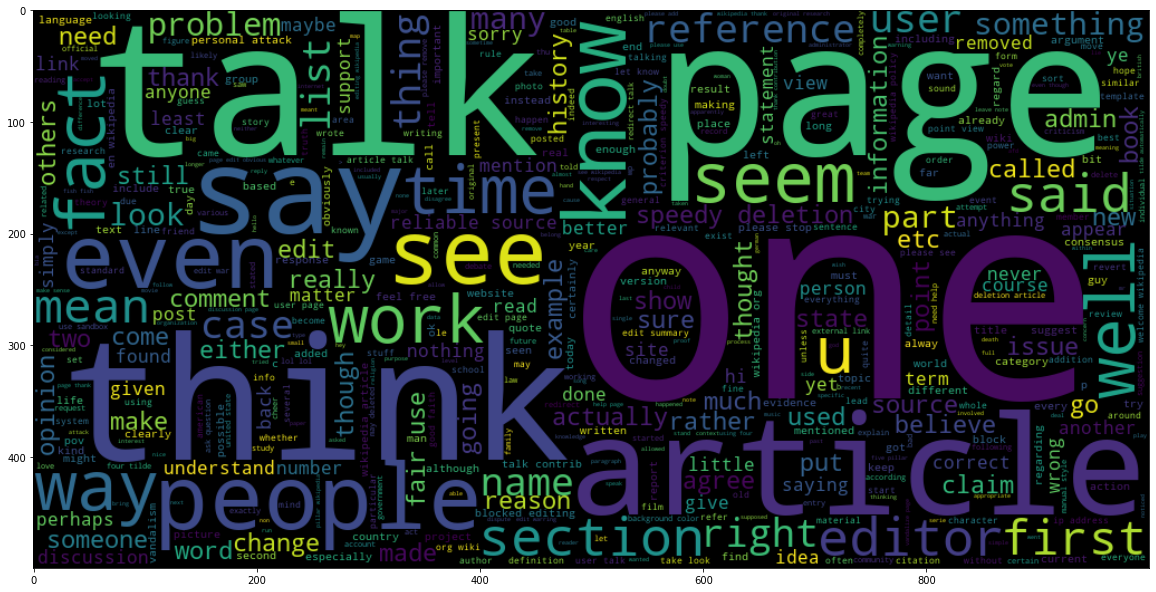

In [9]:
plt.figure(figsize=(20,20))
positive_text = ' '.join(df_pos['text'].values)
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

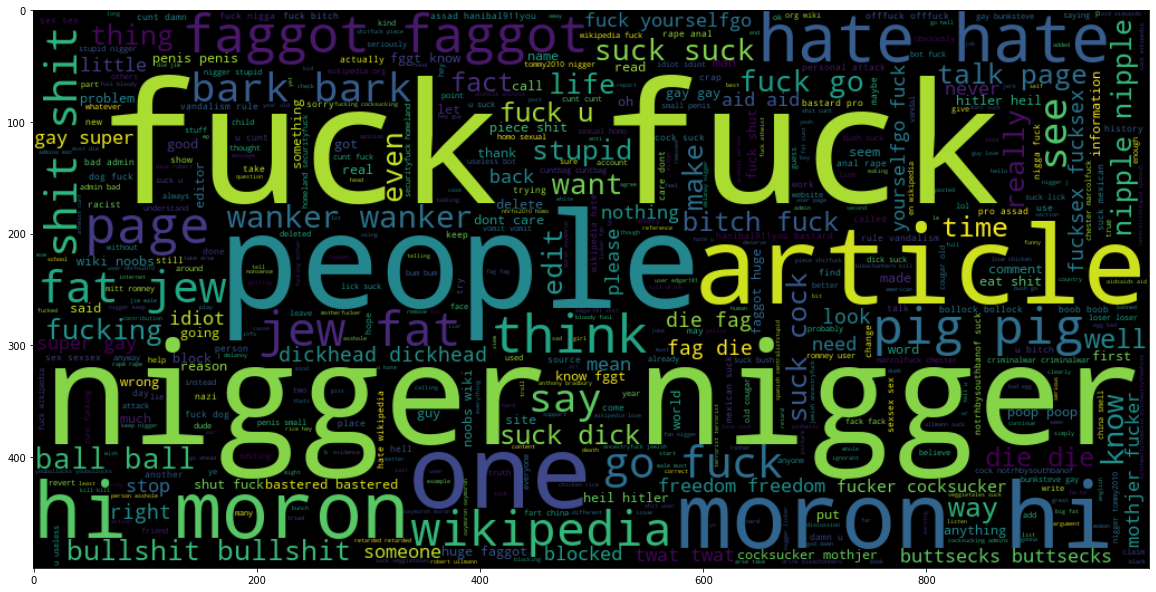

In [10]:
plt.figure(figsize=(20,20))
positive_text = ' '.join(df_neg['text'].values)
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show

### Проверяем баланс классов

In [11]:
print('Соотношение позитивных и негативных комментариев =', round(len(df_pos)/len(df_neg),2))


Соотношение позитивных и негативных комментариев = 8.83


In [12]:
df_neg_upsampled = resample(df_neg,
                                 replace=True,     
                                 n_samples=len(df_pos),   
                                 random_state=1234) 
data = pd.concat([df_pos, df_neg_upsampled])
data['toxic'].value_counts()

0    143346
1    143346
Name: toxic, dtype: int64

### Вывод.
Данные готовы, переходим к обучению.

## Обучение

### Готовим выборки для обучения


In [13]:
target = data['toxic']
features = data.drop(['toxic'], axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=1234)
count_tf_idf = TfidfVectorizer(ngram_range=(2, 2))
features_train = count_tf_idf.fit_transform(features_train['text'])
features_test = count_tf_idf.transform(features_test['text'])

### Дерево решений

In [14]:
start_time = time.time()
model = DecisionTreeClassifier(random_state = 1234)
params = {
   'criterion':['gini', 'entropy'],        
   'max_depth':list(range(1,15,5)) 
}
grid = GridSearchCV(model, params, cv=3, scoring='f1', verbose=True)
grid.fit(features_train,target_train)
print(grid.best_params_,'F1 =', grid.best_score_)
print("Время выполнения %s секунд" % round((time.time() - start_time), 3))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'criterion': 'gini', 'max_depth': 11} F1 = 0.6802648178485932
Время выполнения 2526.981 секунд


In [15]:
start_time = time.time()
model = DecisionTreeClassifier(random_state=1234, 
                              max_depth=grid.best_params_['max_depth'],
                              criterion=grid.best_params_['criterion'])
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print ('F1 =', f1_score(target_test, predictions))
print("Время выполнения %s секунд" % round((time.time() - start_time), 3))


df_smape = pd.DataFrame({'Модель': ['Дерево решений'],
                         'F1': [f1_score(target_test, predictions)],
                         'Время выполнения': [round((time.time() - start_time), 3)]})

F1 = 0.6802689944877164
Время выполнения 31.912 секунд


### Случайный лес

In [16]:
start_time = time.time()
model = RandomForestClassifier(random_state=1234)
parametrs = {'n_estimators':list(range(1,15,5)),
             'max_depth':list(range(1,15,5))}
grid = GridSearchCV(model, parametrs, cv=3, scoring='f1', verbose=True)
grid.fit(features_train,target_train)
print(grid.best_params_,'F1 =', grid.best_score_)
print("Время выполнения %s секунд" % round((time.time() - start_time), 3))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 11, 'n_estimators': 11} F1 = 0.68185770209109
Время выполнения 106.102 секунд


In [17]:
start_time = time.time()
model = RandomForestClassifier(random_state=1234, 
                              max_depth=grid.best_params_['max_depth'],
                              n_estimators=grid.best_params_['n_estimators'])
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print ('F1 =', f1_score(target_test, predictions))
print("Время выполнения %s секунд" % round((time.time() - start_time), 3))

df_smape.loc[len(df_smape.index)] = ['Случайный лес', 
                                     round(f1_score(target_test, predictions),3),
                                     round((time.time() - start_time), 3)]

F1 = 0.6853042836851763
Время выполнения 2.197 секунд


### Логистическая регрессия

In [18]:
start_time = time.time()
model = LogisticRegression(random_state = 1234, class_weight='balanced')
params = {
    'penalty': ['l1', 'l2'],
    'C' : [0.5, 1.0, 5.0, 15.0],
    'intercept_scaling' : range(5, 100, 40),
    'solver' : ['liblinear']}

grid = GridSearchCV(model, params, cv=3, scoring='f1', verbose=True)
grid.fit(features_train, target_train)

print(grid.best_params_,'F1 =', grid.best_score_)
print("Время выполнения %s секунд" % round((time.time() - start_time), 3))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("L

{'C': 15.0, 'intercept_scaling': 5, 'penalty': 'l2', 'solver': 'liblinear'} F1 = 0.981398284944953
Время выполнения 16277.737 секунд


In [19]:
start_time = time.time()
model = LogisticRegression(random_state=1234,
                           class_weight='balanced',
                           penalty=grid.best_params_['penalty'],
                           C=grid.best_params_['C'],
                           intercept_scaling=grid.best_params_['intercept_scaling'],
                           solver=grid.best_params_['solver'])
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('F1 =', round(f1_score(target_test, predictions),3))
print("Время выполнения %s секунд" % round((time.time() - start_time), 3))

df_smape.loc[len(df_smape.index)] = ['Логистическая регрессия', 
                                     round(f1_score(target_test, predictions),3),
                                     round((time.time() - start_time), 3)]

F1 = 0.986
Время выполнения 49.192 секунд


## Выводы

In [20]:
df_smape

,Модель,F1,Время выполнения
0,Дерево решений,0.680269,31.953
1,Случайный лес,0.685000,2.230
2,Логистическая регрессия,0.986000,49.249


### Вывод.
Наилучшей моделью оказалась модель «Логистическая регрессия».
Полученное значение метрики качества F1 составляет 0.986, что существенно больше порогового значения в 0.75. То есть поставленная задача достигнута.
